In [565]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
#import matplotlib as mpl
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation
import numpy as np
#allows custom colours
from dna_features_viewer import BiopythonTranslator
import pandas as pd
from itertools import cycle
import re
import pandas as pd
#allow converting from RGB to CMYK
#import cv2
from PIL import Image
# from PIL import Image
# from io import BytesIO

###note  - use conda env gene_feature_plot


In [566]:
#create a class specifying feature colours
#make feature_list and colour_dict so that each feature name and colour is only added once to legend if more than one share the same name

feature_list = []
colour_dict = {}
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator iplementing the following theme:
    -Colour promoter in pale green
    -colour exons in dark grey
    -colour introns in light grey
    -colour TFs from colour palette"""

    #import colour blind palette
    #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
    # df = pd.read_csv("colourblind_palette.csv", header=0)
    # #convert to floats
    # floats=df.divide(255)
    # #make sets of each row to get the red, green blue colours
    # CB_colour_palette = floats.apply(tuple, axis = 1)
    # #make into df
    # df = CB_colour_palette.to_frame()
    # #save file
    # df.to_csv('../../data/TRAMP/colour_list')
    
    # #turn into a list of colour sets
    # list_colours = list(CB_colour_palette)
    # colour_list = list_colours
    #colour_list = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD']
    colour_list = ['#2271B2',
    '#3DB7E9',
    '#F748A5',    
    '#d55e00',
    '#e69f00',
    '#f0e442',
    '#000000',]
    #make colour iterator
    colour_iterator=cycle(colour_list)
    #change colour cycle
    #mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=list_colours)
    #count = -1
    #set colour count


    def compute_feature_color(self, feature):
        """set colour of each feature"""      

        if feature.type == "promoter":
            return "#359B73"
        elif feature.type == "exon":
            return "darkgrey"
            #return (169,169,169)
        elif feature.type == "intron":
            return "lightgrey"  
            #return (211,211,211)
        elif feature.type == "5'UTR":
            return "lightgrey"
        elif feature.type == "TFBS":
            if feature.qualifiers.get("label")[0] in colour_dict.keys():
                col = colour_dict[feature.qualifiers.get("label")[0]]
            else:
                col = next(self.colour_iterator)
                colour_dict[feature.qualifiers.get("label")[0]] = col
                        
            return col
        else:
            return "gold"

    def compute_feature_box_linewidth(self, feature):
        """change shape of features"""
        return 0

    def compute_feature_label(self, feature):
        """Remove feature labels"""
        #return super().compute_feature_label(feature)
        

    def compute_feature_fontdict(self, feature):
        """change font to arial, size to 10"""
        return dict(family='sans-serif',size=10)
        #return dict([('family','sans-serif'),('sans-serif','Arial'),('size',10)])

    #make feature_list so that each feature name is only added once if more than one share the same name
    #feature_list = []
    def compute_feature_legend_text(self, feature):
        """add legend if feature label has not been added to legend already"""
        if feature.type=='promoter':
            pass
        elif feature.type=='exon':
            pass
        elif feature.type=='intron':
            pass
        elif feature.type=="5'UTR":
            pass
        # elif feature.qualifiers.get("label")[0] in self.feature_list:
        #     pass
        elif feature.qualifiers.get("label")[0] in feature_list:
            pass
        else:
            
            feature_list.append(feature.qualifiers.get("label")[0])
                 
            #feature_list.append(feature.qualifiers.get("label")[0])
            return feature.qualifiers.get("label")[0]     


    def compute_filtered_features(self, features):
        """Do not display features the following features"""
        return [
            feature for feature in features
            if (feature.type != "TRAMP_probe")
            and (feature.type != "none")
            and (feature.type != "DHS")
            and (feature.type != "misc_feature")
            and (feature.type != "primer")
            and (feature.type != "gene")
            and (feature.qualifiers.get("label")[0] != "ARID5_ARID6"
            and (feature.qualifiers.get("label")[0] != "ARDI5_ARID6"))
            ]
        

In [567]:
def preprocess_record(seqrecord):
    """Preprocess the biopython record before feeding it into the translator."""
    #get length of the whole sequence
    #seq_length = len(seqrecord.seq)
    # #print(f'{seqrecord.id} + {seq_length}')
    # #change seqrecord locations
    # #if start location is greater than TSS position then the new location is the length of the whole sequence minus the original position
    # def convert_location(location, TSS_position, seq_length):
    #     """convert locations to be relative to TSS position (or another locaton if you choose)"""
    #     if location > TSS_position:
    #         new_location = seq_length - location
    #     elif location < TSS_position:
    #         new_location = -(TSS_position-location)
    #     elif location == TSS_position:
    #         new_location = 0
    #     return new_location
    # print(seqrecord)
    #Ensure that genbank files are reverse complemented so that plots can be aligned to the right in figure
    new_seqrecord = seqrecord.reverse_complement(id=seqrecord.id +"_rc")
    
    for feature in new_seqrecord.features:
        #change strand to None so that features are rectangular
        feature.location.strand = None 
        
          
        if feature.type == 'TFBS':
            #print(feature)
            #change sigil to box
            feature.qualifiers["sigil"] = 'OCTAGON'
            #increase width of TFBS so colour is more visible
            start = feature.location.start
            end = feature.location.end
            #find middle of TFBS
            middle = (end-start)//2 #floor division creating an integar
            
            new_start = start-20+middle
            new_end = end-middle+20
            feature.location = FeatureLocation(new_start,new_end)    
         

            #if feature was experimentally validated, add qualifier
            
    return new_seqrecord



In [568]:
def gb_file_to_seqrecord(promoter_name):
    """load genbankfile into a seqrecord"""
    #file location
    gb_file=f"../../data/TRAMP/{promoter_name}.gb"
    record = SeqIO.read(gb_file, 'genbank')
    #preprocess record
    modified_seqrecord = preprocess_record(record)
    return modified_seqrecord

In [569]:
def RGB2CMYK(image_file_location, image_file_extension):
    """convert image from RGB to CMYK colours"""
    # Import image
    image = Image.open(image_file_location+image_file_extension)
    print(image.mode)
    if image.mode == 'RGBA':
        print('converting_image')
        cmyk_image = image.convert('CMYK')
        cmyk_image.save(image_file_location+'_CMYK'+image_file_extension)
    #close image
    image.close()
    # img = plt.imread(image_file_location+image_file_extension)
    # #print(image_file_location+image_file_extension)
    # # Create float
    # bgr = img.astype(float)/255.

    # # Extract channels
    # with np.errstate(invalid='ignore', divide='ignore'):
    #     K = 1 - np.max(bgr, axis=2)
    #     C = (1-bgr[...,2] - K)/(1-K)
    #     M = (1-bgr[...,1] - K)/(1-K)
    #     Y = (1-bgr[...,0] - K)/(1-K)

    # # Convert the input BGR image to CMYK colorspace
    # CMYK = (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)
    # cv2.imwrite(image_file_location+'_CMYK'+image_file_extension, CMYK)

    # # Split CMYK channels
    # Y, M, C, K = cv2.split(CMYK)

    # np.isfinite(C).all()
    # np.isfinite(M).all()
    # np.isfinite(K).all()
    # np.isfinite(Y).all()

    # # Save channels
    # cv2.imwrite('C:/path/to/C.jpg', C)
    # cv2.imwrite('C:/path/to/M.jpg', M)
    # cv2.imwrite('C:/path/to/Y.jpg', Y)
    # cv2.imwrite('C:/path/to/K.jpg', K)


In [570]:
#create a class specifying feature colours
#make feature_list and colour_dict so that each feature name and colour is only added once to legend if more than one share the same name

feature_list = []
colour_dict = {}
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator iplementing the following theme:
    -Colour promoter in pale green
    -colour exons in dark grey
    -colour introns in light grey
    -colour TFs from colour palette"""

    #import colour blind palette
    #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
    # df = pd.read_csv("colourblind_palette.csv", header=0)
    # #convert to floats
    # floats=df.divide(255)
    # #make sets of each row to get the red, green blue colours
    # CB_colour_palette = floats.apply(tuple, axis = 1)
    # #make into df
    # df = CB_colour_palette.to_frame()
    # #save file
    # df.to_csv('../../data/TRAMP/colour_list')
    
    # #turn into a list of colour sets
    # list_colours = list(CB_colour_palette)
    # colour_list = list_colours
    #colour_list = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD']
    colour_list = ['#2271B2',
    '#3DB7E9',
    '#F748A5',    
    '#d55e00',
    '#e69f00',
    '#f0e442',
    '#000000',]
    #make colour iterator
    colour_iterator=cycle(colour_list)
    #change colour cycle
    #mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=list_colours)
    #count = -1
    #set colour count


    def compute_feature_color(self, feature):
        """set colour of each feature"""      

        if feature.type == "promoter":
            return "#359B73"
        elif feature.type == "exon":
            return "darkgrey"
            #return (169,169,169)
        elif feature.type == "intron":
            return "lightgrey"  
            #return (211,211,211)
        elif feature.type == "5'UTR":
            return "lightgrey"
        elif feature.type == "TFBS":
            if feature.qualifiers.get("label")[0] in colour_dict.keys():
                col = colour_dict[feature.qualifiers.get("label")[0]]
            else:
                col = next(self.colour_iterator)
                colour_dict[feature.qualifiers.get("label")[0]] = col
                        
            return col
        else:
            return "gold"

    def compute_feature_box_linewidth(self, feature):
        """change shape of features"""
        return 0

    def compute_feature_label(self, feature):
        """Remove feature labels"""
        #return super().compute_feature_label(feature)
        

    def compute_feature_fontdict(self, feature):
        """change font to arial, size to 10"""
        return dict(family='sans-serif',size=10)
        #return dict([('family','sans-serif'),('sans-serif','Arial'),('size',10)])

    #make feature_list so that each feature name is only added once if more than one share the same name
    #feature_list = []
    def compute_feature_legend_text(self, feature):
        """add legend if feature label has not been added to legend already"""
        if feature.type=='promoter':
            pass
        elif feature.type=='exon':
            pass
        elif feature.type=='intron':
            pass
        elif feature.type=="5'UTR":
            pass
        # elif feature.qualifiers.get("label")[0] in self.feature_list:
        #     pass
        elif feature.qualifiers.get("label")[0] in feature_list:
            pass
        else:
            
            feature_list.append(feature.qualifiers.get("label")[0])
                 
            #feature_list.append(feature.qualifiers.get("label")[0])
            return feature.qualifiers.get("label")[0]     


    def compute_filtered_features(self, features):
        """Do not display features the following features"""
        return [
            feature for feature in features
            if (feature.type != "TRAMP_probe")
            and (feature.type != "none")
            and (feature.type != "DHS")
            and (feature.type != "misc_feature")
            and (feature.type != "primer")
            and (feature.type != "gene")
            and (feature.qualifiers.get("label")[0] != "ARID5_ARID6"
            and (feature.qualifiers.get("label")[0] != "ARDI5_ARID6"))
            ]
        

In [571]:
def make_plot(dictionary_of_records_seqrecords,dictionary_of_records_promoternames):
    def make_graphic_record(seqrecord, promoter_name, ax):
        """make a graphic record object"""
        #display figure    
        graphic_record = MyCustomTranslator().translate_record(seqrecord)
        #change height to 0 so TFBS can overlap the promoter
        graphic_record.feature_level_height = 0
        #graphic_record = BiopythonTranslator().translate_record(gb_file)
        graphic_record.plot(ax=ax, with_ruler=True)#,figure_width=10, #strand_in_label_threshold=4
        
        #add title of promoter
        ax.title.set_text(promoter_name)
        #return graphic_record

    #length of dictionary
    length_dict = len(dictionary_of_records_promoternames)
    #make gridspec plot
    height = length_dict
    fig = plt.figure(constrained_layout=True,figsize=(14,height))
    #make subfigures
    subfigs = fig.subfigures(1,2, wspace=0.07)
    #left legend 
    axsLeft=subfigs[0].subplots(1,1)
    #remove axis
    axsLeft.axis('off')
    #right figures
    axsRight = subfigs[1].subplots(length_dict,1,sharex=True)
    #make graphic records
    for k,v in dictionary_of_records_seqrecords.items():
        #take last character of string
        last = int(k[-1])
        #get promoter name
        prom_name = dictionary_of_records_promoternames[k]
        #split on dashes
        short_prom_name = prom_name.split('-')[0].upper()
        make_graphic_record(v,short_prom_name,axsRight[last-1])

    #add legend
    #first import colour iterator
    #import colour blind palette
    #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
    df = pd.read_csv("colourblind_palette.csv", header=0)
    #convert to floats
    floats=df.divide(255)
    #make sets of each row to get the red, green blue colours
    CB_colour_palette = floats.apply(tuple, axis = 1)
    #turn into a list of colour sets
    list_colours = list(CB_colour_palette)
    #make colour iterator
    colour_iterator=cycle(list_colours)
    #Use feature_list generated just above the Class MyCustomTranslator(BiopythonTranslator)
    #iterate creating legend from feature list
    #create empty handles list
    #print(colour_dict)
    handles = []
    for TFBS,colour in colour_dict.items():
        addition = mpatches.Patch(color=colour, label=TFBS)
        #append to handles list
        handles.append(addition)
        
    axsLeft.legend(handles=handles)
    

    #change x_lim to flip x axis
    for ax in axsRight:
        ax.set_xlim(4550,0)

    x_ticks = np.arange(176, 4550, 500) #start stop and step
    plt.xticks(x_ticks)
    #Now change labels of xticks centered around the TSS    
    fig.canvas.draw()
    labels = [item._text for item in axsRight[length_dict-1].get_xticklabels()]
    #labels: ['176', '676', '1,176', '1,676', '2,176', '2,676', '3,176', '3,676', '4,176']
    new_labels = []
    for label in labels:
        #remove non-numberic character from string
        label = re.sub("[^0-9]","",label)                
        label = 1176-int(label)
        if label == 0:
            label = f'{0} (TSS)'

        new_labels.append(label)
    
    #print(int(labels[1])+2)
    axsRight[length_dict-1].set_xticklabels(new_labels)
    #print(colour_iterator)

    #combine graphic records
    #all_records = [graphic_record1,graphic_record2]
    #print(feature_list)
    #create figure legend
    # lines_labels = [graphic_record.get_legend_handles_labels() for graphic_record in axsRight]
    # handles, labels = [sum(l, []) for l in zip(*lines_labels)]
    # fig.legend(handles, labels)

    #subfigs[1].suptitle('Promoters', fontsize='x-large')
    
    # #make subplots
    # fig, (ax1,ax2) = plt.subplots(
    #     1,2, figsize=(12,4),gridspec_kw={'width_ratios':[1,4]}
    # )
    #plot Record Map
    
    #add legend of last record
    #graphic_record1.plot_legend(ax=axsLeft, loc=1, ncol=1, frameon=True)
   
    #set DPI to 600
    fig.set_dpi(600)
    #fig.tight_layout()
    fig.savefig(f"../../data/TRAMP/plots/combined.svg")
    fig.savefig(f"../../data/TRAMP/plots/combined.tiff")
    #convert image from RGB to CMYK
    RGB2CMYK('../../data/TRAMP/plots/combined', '.tiff')
    # #save figure into memory
    # svg1 = BytesIO()
    # fig.savefig(svg1)
    # #load image into PIL
    # svg2 = Image.open(svg1)
    # #save as TIFF
    # svg2.save(f"../../data/TRAMP/plots/combined2.tiff")
    # svg1.close()
    

In [572]:
def main(args):
    # parse arguments
    #args = parse_args(args)
    #dependent_variable = "GC_content"

    # make directory for the plots to be exported to
    dirName = f"../../data/TRAMP/plots"
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory ", dirName, " created")
    except FileExistsError:
        print("Directory ", dirName, " already exists")
    #create dictionary of promoter names
    promoter_names=dict([('promoter_name1',"nlp7-at4g24020-3kbcds0-5kb"),
    ('promoter_name2',"nlp6-at1g64530-3kbcds0-5kb"),
    ('promoter_name3',"tga1-at5g65210-3kbcds0-5kb"),
    ('promoter_name4',"arf18-at3g61830-3kbcds0-5kb"),
    ('promoter_name5',"arf9-at4g23980-3kbcds0-5kb"),
    ('promoter_name6',"anac032-at1g77450-3kbcds0-5kb"),
    ('promoter_name7',"anr1-at2g14210-3kbcds0-5kb"),
    ('promoter_name8',"dreb26-at1g21910-3kbcds0-5kb"),
    ('promoter_name9',"nir1-at2g15620-3kbcds0-5kb")])
    
    #load seqrecords
    #create empty dictionary
    seqrecords = {}
    for k,v in promoter_names.items():             
        #add to new dictionary of seqrecords
        seqrecords[k] = gb_file_to_seqrecord(v)
    
    #make plot using dictionary
    make_plot(seqrecords,promoter_names)



Directory  ../../data/TRAMP/plots  already exists
RGBA
converting_image


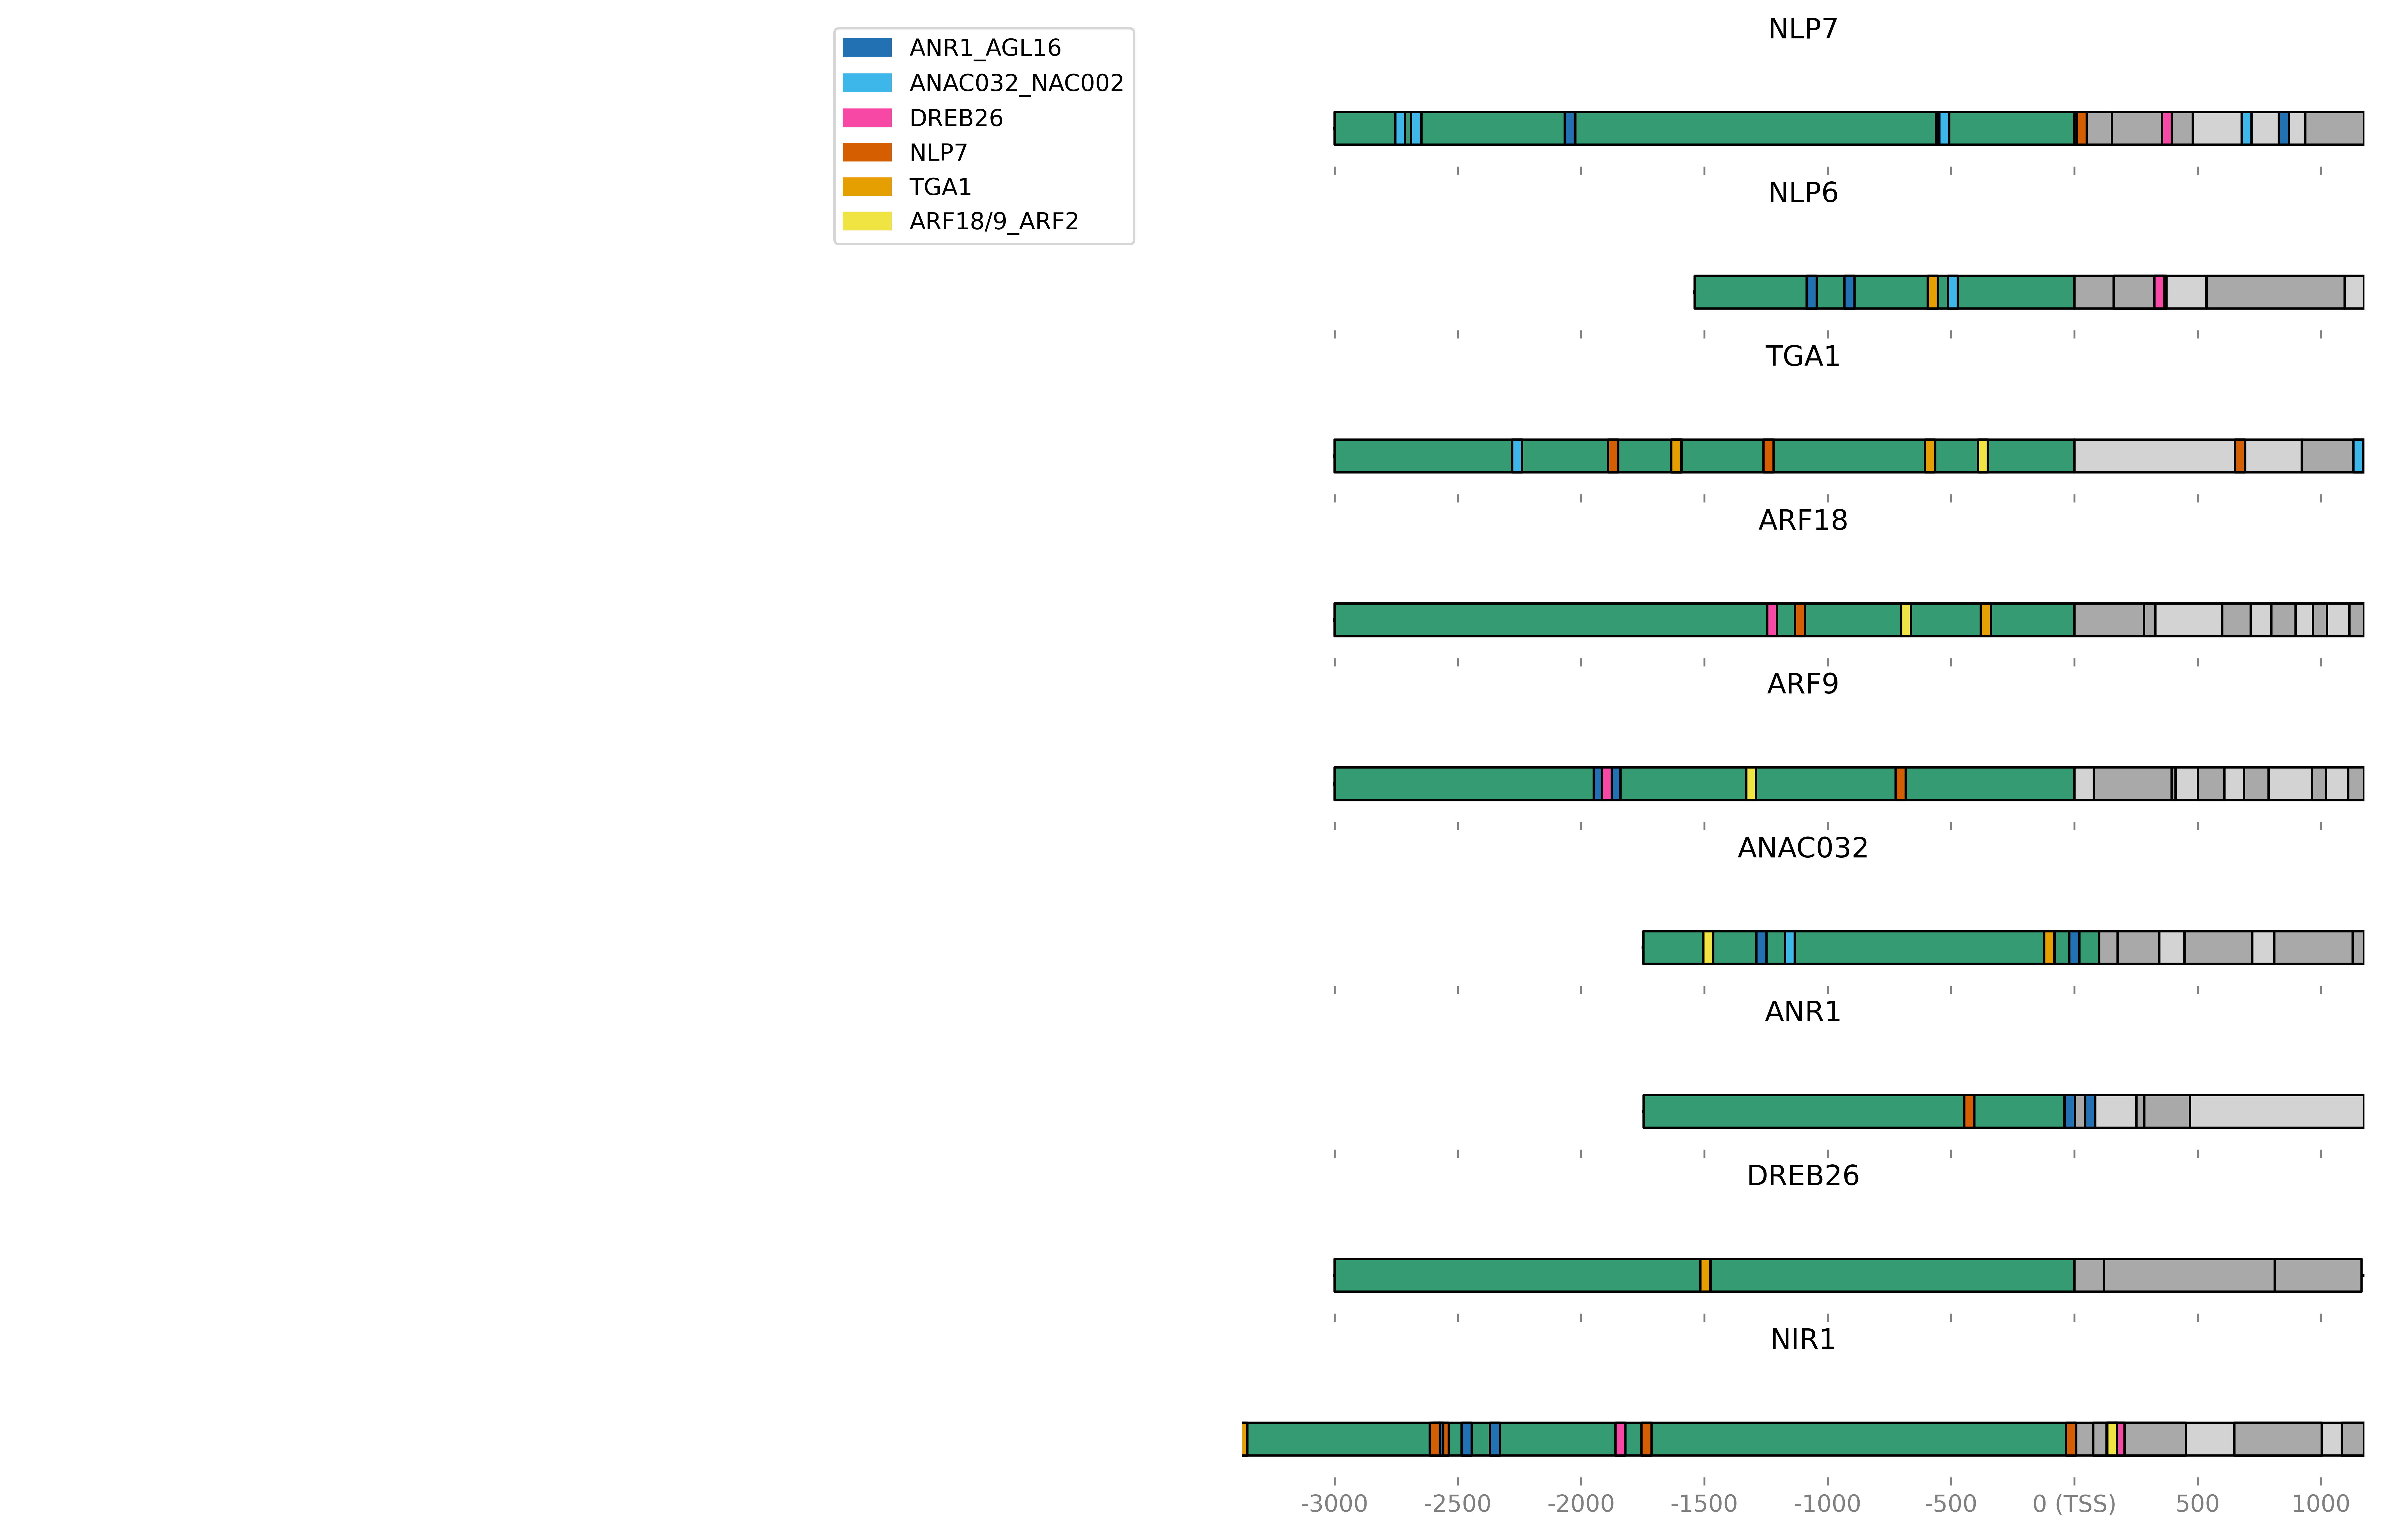

In [573]:
if __name__ == "__main__":
    import sys

    main(sys.argv[1:])